<a href="https://colab.research.google.com/github/RosanaAlves/Descargas-Atmosfericas/blob/main/Analise_Descritiva_v01_11-12-23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analises descritivas sobre descargas atmosféricas no estado de Minas Gerais


Este estudo conta com dados de descargas atmosféricas coletadas durante o ano de 2022 no Estado de Minas Gerais.

De acordo com o INPE (Instituto Nacional de Pesquisas Espaciais), descargas atmosféricas são descargas elétricas de grande extensão (alguns quilômetros) e de grande intensidade (picos de intensidade de corrente acima de um quiloàmpere), que ocorrem devido ao acúmulo de cargas elétricas em regiões localizadas da atmosfera, em geral dentro de tempestades.
Elas podem ocorrer tanto no interior de uma nuvem, como entre nuvens ou entre uma nuvem e a terra.

É importante estudar esse tipo de evento, a fim de poder evitá-lo ou ainda, reduzir seus efeitos. Através de análises, é possível verificar a existência de algum tipo de padrão em sua ocorrência, principalmente,  no caso de descargas entre nuvem e terra.
Essas descargas podem ocasionar muitos prejuízos em plantações, criações de animais e aparelhos eletrodomésticos.

 Sendo assim, o objetivo deste estudo é fazer uma análise descritiva dos dados, utilizando linguagem Python. Os resultados são apenas para apontamentos e suposições que poderão ser aprofundadas em um estudo posterior.


In [46]:
# pip install folium
# pip install geopandas matplotlib

## Análise descritiva

In [47]:
# Bibliotecas

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import folium
import geopy
import geopandas as gpd
from shapely.geometry import Point


In [48]:
# Carregando o arquivo csv

dados_df = pd.read_csv("https://raw.githubusercontent.com/RosanaAlves/Descargas-Atmosfericas/main/dataset_2022.csv")
dados_df;

In [49]:
# Alterando a primeira letra do nome de cada coluna

dados_df.columns = dados_df.columns.str.strip().str.capitalize()
dados_df

,Data,Latitude,Longitude,Tipo
0,2022-01-01 16:55:56-03:00,-20.326783,-45.989391,0
1,2022-01-01 16:55:56-03:00,-20.322183,-45.987291,0
2,2022-01-01 16:55:56.985000-03:00,-20.337263,-45.975291,1
3,2022-01-01 16:55:56.997000-03:00,-20.334103,-45.985891,0
4,2022-01-01 16:55:57-03:00,-20.333383,-46.018591,0
...,...,...,...,...
220696,2022-12-31 21:14:53.433000-03:00,-19.867303,-45.706591,1
220697,2022-12-31 21:14:53.455790-03:00,-19.898383,-45.744691,1
220698,2022-12-31 21:17:14.225225-03:00,-19.898783,-45.743891,1
220699,2022-12-31 21:19:20.140002-03:00,-19.850383,-45.746191,1


In [50]:
# Verificando o formato da coluna Data

df = dados_df
df['Data'];

In [51]:
# Alterando o formato da coluna Data para data e hora.

df['Data'] = pd.to_datetime(df['Data'])
df['Data'];

In [52]:
# Estatisticas descritivas

df.describe()

,Latitude,Longitude,Tipo
count,220701.000000,220701.000000,220701.000000
mean,-20.036394,-45.992885,0.664881
std,0.213697,0.233236,1.014207
min,-20.468373,-46.430891,0.000000
25%,-20.206683,-46.196691,0.000000
50%,-20.039283,-45.997491,1.000000
75%,-19.871303,-45.800191,1.000000
max,-19.569583,-45.526391,40.000000


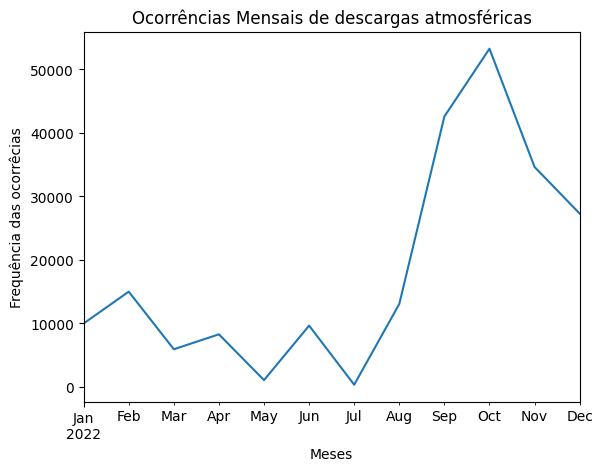

In [53]:
# Plotando a contagem de descargas por mês

df.set_index('Data').resample('M').size().plot() # Agrupando por mês
plt.title('Ocorrências Mensais de descargas atmosféricas')
plt.xlabel('Meses')
plt.ylabel('Frequência das ocorrêcias')
plt.show()


Segundo INMET (Instituto Nacional de Meteorologia), a estação chuvosa em Minas Gerais, assim como, em toda a Região Sudeste, ocorre entre os meses de outubro a março, porém as primeiras pancadas de chuva, normalmente ocorrem na segunda quinzena de setembro, evidenciando o declínio da estação seca.


Olhando para o gráfico, as maiores ocorrências de descargas atmosféricas ocorreram entre agosto e dezembro de 2022, tendo seu maior pico em outubro. Exatamente como era esperado, já que é período de chuvas. Contudo, esse pico pode evidenciar que a transição para a estação chuvosa influencia a incidência de raios, pois, após esse pico houve uma queda nas ocorrências.


In [54]:
# Frequencia de descargas por tipo de descarga

df['Tipo'].value_counts()

1     142180
0      78407
40       114
Name: Tipo, dtype: int64

O tipo (0) indica descarga nuvem-solo e o tipo (1) intranuvem, o tipo (40) não foi declarado, por isso, pode ser considerado um valor inconsistente.
Os valores inconsistentes não podem ser apagados sem antes serem analisados, sendo assim, é necessário uma investigação mais profunda.

In [55]:
# Selecionando apenas o periodo de maior incidencia de descargas

df_me = df[(df['Data'] >= '2022-08-01') & (df['Data'] <= '2022-12-31')] # me- mudanca de estacao
df_me.shape
df_me['Tipo'].value_counts()


1     116729
0      53829
40       114
Name: Tipo, dtype: int64

Todas as ocorrências do valor (40), foram durante a estação chuvosa.


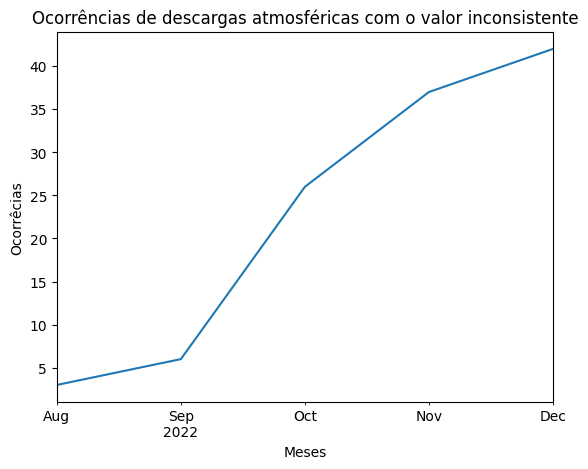

In [56]:
# filtrando valor inconsistente

df_filtrado = df[df['Tipo'] == 40]

df_filtrado.set_index('Data').resample('M').size().plot() # Agrupando por mês
plt.title('Ocorrências de descargas atmosféricas com o valor inconsistente')
plt.xlabel('Meses')
plt.ylabel('Ocorrêcias')
plt.show()


As ocorrências do valor inconsistente tiveram um comportamento crescente.


In [58]:
# Criando um objeto Geocoder
geocoder = geopy.Nominatim(user_agent="my_user_agent")

for lat, lng in zip(df_filtrado['Latitude'], df_filtrado['Longitude']):
    location = geocoder.reverse((lat, lng))


df_filtrado['Nome'] = location.address

<ipython-input-58-7123ac8f334e>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [59]:
df_filtrado['Nome'].unique;


In [ ]:
# Coordenadas da primeira linha

latitude_ = -19.742283
longitude_ = -46.301591

# Criando um mapa em Minas Gerais
mapa_mg = folium.Map(location=[latitude_, longitude_], zoom_start=12)

# Adicionando marcadores para cada ponto no DataFrame
for index, row in df_filtrado.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Nome'],
        icon=folium.Icon(color='red')
    ).add_to(mapa_mg)

# Exibindo o mapa
mapa_mg




Os valores discrepantes estão localizados em Bambuí, na Região Geográfica Imediata de Formiga,  mostrando que os pontos estão próximos. Isso pode indicar que  esses valores foram coletados pelo mesmo local e de maneira errada. Contudo, antes de tomar qualquer medida referente a eles, é necessário entrar em contato com o órgão que os coletou, se possível.

Seguiremos trabalhando apenas com a ocorrência do evento nuvem-solo.









## Analisando apenas as descargas nuvem-solo


In [60]:
df_me_ns = df_me[df_me['Tipo'] == 0] # me- mudanca de estacao e ns-nuvem-solo
df_me_ns;


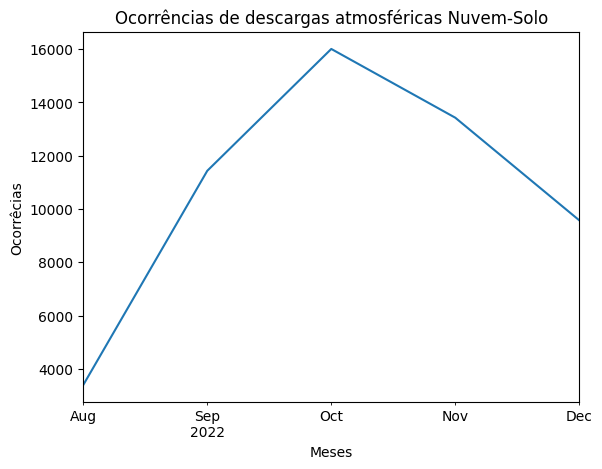

In [ ]:
df_me_ns.set_index('Data').resample('M').size().plot() # Agrupando por mês
plt.title('Ocorrências de descargas atmosféricas Nuvem-Solo')
plt.xlabel('Meses')
plt.ylabel('Ocorrêcias')
plt.show()

Das mais de 50.000 descargas que ocorreram em outubro , 16. 000 eram do tipo nuvem- solo. Elas representam 32% do total, quase um terço das descargas.


In [61]:
# Coordenadas da primeira linha

latitude_= -19.742283
longitude_ = -46.301591

# Criando um mapa em Minas Gerais
mapa_mg = folium.Map(location=[latitude_, longitude_], zoom_start=12)

# Adicionando marcadores para cada ponto no DataFrame
for index, row in df_me_ns.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
         popup=row['Tipo'],
        icon=folium.Icon(color='red')
    ).add_to(mapa_mg)

# Exibindo o mapa
mapa_mg

In [63]:
import plotly.express as px

latitude_p = -19.742283
longitude_p = -46.301591

# Criando um mapa usando Plotly Express
figura = px.scatter_geo(df_me_ns, lat='Latitude', lon='Longitude',  size_max=30)

figura.update_geos(center=dict(lon=longitude_p, lat=latitude_p), projection_scale=7)

# Exibindo o mapa
figura.show()


## Conclusão
Como o esperado, a maior incidência de raios ocorreram durante a estação chuvosa, que vai de outubro a março, como maior pico em outubro,  evidenciando que o maior indício de descargas é exatamente durante a mudança de estação.

## Referências

INMET. Estação chuvosa em Minas Gerais. Disponível em: https://portal.inmet.gov.br/uploads/notastecnicas/Nota_tecnica_CEDEC_04_17.pdf


INPE. O que são descargas atmosféricas. Disponível em:
http://www.inpe.br/webelat/rindat/menu/desc.atm/#:~:text=Descargas%20atmosf%C3%A9ricas%20s%C3%A3o%20descargas%20el%C3%A9tricas,em%20geral%20dentro%20de%20tempestades.

